# Notebook configuration

## Install

In [1]:
#!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.5 MB/s eta 0:00:00

## Import

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
from typing import List, Tuple, Union, Dict
import time

from darts import TimeSeries
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.dataprocessing.transformers.scaler import Scaler
from darts.models import TiDEModel, NaiveMovingAverage, TFTModel
from darts.metrics import mae, mse, smape
from darts.utils.losses import MAELoss
import darts

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Data

In [3]:
## Mount Google Drive if using collab
#from google.colab import drive
#drive.mount('/content/drive')

# Define the path to your data
local_path = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sales_data = pd.read_csv(f'{local_path}/price_sales_promotion.csv')
volume_data = pd.read_csv(f'{local_path}/historical_volume.csv')
events_data = pd.read_csv(f'{local_path}/event_calendar.csv')

## Functions

In [5]:
def rotation_tags(
    dataset: pd.DataFrame,
    interval_length_list: List[int],
    threshold_list: List[float],
) -> pd.DataFrame:
    max_date = dataset['Date'].max()
    result_df = dataset.copy()
    result_df['Rotation'] = 'high'

    for interval_length, threshold in zip(interval_length_list, threshold_list):
        min_date = max_date - timedelta(days=interval_length)
        interval_length_month = interval_length//30

        # Filter
        df_rotation = dataset[(dataset['Date'] <= max_date) & (dataset['Date'] > min_date)].copy()

        # Frequency calculation
        df_sum_rotation = df_rotation[df_rotation['Volume'] > 0].copy()
        df_sum_rotation = df_sum_rotation.groupby(['Agency', 'Product'], as_index=False).agg(
            n_sale_months=('Volume', 'count')
        )

        # Compute coverage in months
        df_sum_rotation['interval_coverage'] = df_sum_rotation['n_sale_months'] / interval_length_month

        # Compute rotation tags
        df_sum_rotation['rotation_current'] = np.where(
            df_sum_rotation['interval_coverage'] < threshold, 'low', 'high'
        )

        # Merge
        result_df = result_df.merge(
            df_sum_rotation[['Agency', 'Product', 'rotation_current']],
            on=['Agency', 'Product'],
            how='left'
        )

        # Update 'low' rotation
        result_df['Rotation'] = np.where(
            result_df['rotation_current'] == 'low', 'low', result_df['Rotation']
        )
        result_df['Rotation'] = np.where(
            result_df['rotation_current'].isna(), 'low', result_df['Rotation']
        )

        result_df.drop(columns=['rotation_current'], inplace=True)

    # Fill NaN as 'low'
    result_df['Rotation'] = result_df['Rotation'].fillna('low')
    result_df.reset_index(drop=True, inplace=True)

    return result_df[['Agency','Product','Rotation']].drop_duplicates().reset_index(drop=True)

In [6]:
def to_darts_time_series_group(
    dataset: pd.DataFrame,
    target: Union[List[str],str],
    time_col: str,
    group_cols: Union[List[str],str],
    static_cols: Union[List[str],str]=None,
    past_cols: Union[List[str],str]=None,
    future_cols: Union[List[str],str]=None,
    freq: str=None,
    encode_static_cov: bool=True,
)-> Tuple[List[TimeSeries], List[TimeSeries], List[TimeSeries], List[TimeSeries]]:

    series_raw = TimeSeries.from_group_dataframe(
    dataset,
    time_col    =   time_col,
    group_cols  =   group_cols,  # individual time series are extracted by grouping `df` by `group_cols`
    static_cols =   static_cols,  # also extract these additional columns as static covariates (without grouping)
    value_cols  =   target,  # optionally, specify the time varying columns
    n_jobs      =   -1,
    verbose     =   False,
    freq        =   freq,
    )

    if encode_static_cov:
        static_cov_transformer = StaticCovariatesTransformer()
        series_encoded = static_cov_transformer.fit_transform(series_raw)
    else: series_encoded = []

    if past_cols:
        past_cov = TimeSeries.from_group_dataframe(
            dataset,
            time_col    =   time_col,
            group_cols  =   group_cols,
            value_cols  =   past_cols,
            n_jobs      =   -1,
            verbose     =   False,
            freq        =   freq,
            )
    else: past_cov = []

    if future_cols:
        future_cov = TimeSeries.from_group_dataframe(
            dataset,
            time_col    =   time_col,
            group_cols  =   group_cols,
            value_cols  =   future_cols,
            n_jobs      =   -1,
            verbose     =   False,
            freq        =   freq,
            )
    else: future_cov = []

    return series_raw, series_encoded, past_cov, future_cov

In [7]:
def split_grouped_darts_time_series(
    series: List[TimeSeries],
    split_date: Union[str, pd.Timestamp],
    min_date: Union[str, pd.Timestamp]=None,
    max_date: Union[str, pd.Timestamp]=None,
) -> Tuple[List[TimeSeries], List[TimeSeries]]:

    if min_date:
       raw_series = series.copy()
       series = []
       for s in raw_series:
        try: series.append(s.split_before(pd.Timestamp(min_date)-timedelta(1))[1])
        except: series.append(s)

    if max_date:
       raw_series = series.copy()
       series = []
       for s in raw_series:
        try: series.append(s.split_before(pd.Timestamp(max_date))[0])
        except: series.append(s)

    split_0 = [s.split_before(pd.Timestamp(split_date))[0] for s in series]
    split_1 = [s.split_before(pd.Timestamp(split_date))[1] for s in series]
    return split_0, split_1

In [8]:
def eval_forecasts(
    pred_series: Union[List[TimeSeries], TimeSeries],
    test_series: Union[List[TimeSeries], TimeSeries],
    error_metric: darts.metrics,
    plot: bool=False
) -> List[float]:

    errors = error_metric(test_series, pred_series)
    if plot:
        plt.figure()
        plt.hist(errors, bins=50)
        plt.ylabel("Count")
        plt.xlabel("Error")
        plt.title(f"Mean error: {np.mean(errors):.3f}")
        plt.show()
        plt.close()
    return errors

In [9]:
def eval_local_model(
    train_series: List[TimeSeries],
    test_series: List[TimeSeries],
    model_cls,
    error_metric: darts.metrics,
    prediction_horizon: int,
    **model_kwargs
) -> Tuple[List[float], float, Union[List[TimeSeries], TimeSeries]]:

    preds = []
    start_time = time.time()
    for series in train_series:
        model = model_cls(**model_kwargs)
        model.fit(series)
        pred = model.predict(n=prediction_horizon)
        preds.append(pred)
    elapsed_time = time.time() - start_time

    errors = eval_forecasts(preds, test_series, error_metric=error_metric, plot=True)
    return errors, elapsed_time, preds

In [10]:
def fit_mixed_covariates_model(
    model_cls,
    common_model_args: dict,
    specific_model_args: dict,
    model_name: str,
    past_cov: Union[List[TimeSeries], TimeSeries],
    future_cov: Union[List[TimeSeries], TimeSeries],
    train_series: Union[List[TimeSeries], TimeSeries],
    val_series: Union[List[TimeSeries], TimeSeries],
    max_samples_per_ts: int=None,
    save:bool=False,
    path:str="",
):

    # Declarare model
    model = model_cls(model_name=model_name,
                    **common_model_args,
                    **specific_model_args)

    # Train model
    model.fit(
                    # TRAIN ARGS ===================================
                    series                = train_series,
                    past_covariates       = past_cov,
                    future_covariates     = future_cov,
                    max_samples_per_ts    = max_samples_per_ts,
                    # VAL ARGS ======================================
                    val_series            = val_series,
                    val_past_covariates   = past_cov,
                    val_future_covariates = future_cov,
                )

    if save: model.save(path)

In [11]:
def backtesting(model, series, past_cov, future_cov, start_date, horizon, stride):
  historical_backtest = model.historical_forecasts(
    series, past_cov, future_cov,
    start=start_date,
    forecast_horizon=horizon,
    stride=stride,  # Predict every N months
    retrain=False,  # Keep the model fixed (no retraining)
    overlap_end=False,
    last_points_only=False
  )
  maes = model.backtest(series, historical_forecasts=historical_backtest, metric=mae)

  return np.mean(maes)

In [ ]:
def process_predictions(
    preds: List[TimeSeries],
    series_raw: List[TimeSeries],
    group_cols: List[str]
) -> pd.DataFrame:

    list_df = [serie.pd_dataframe() for serie in preds]
    for i in range(len(list_df)):
      list_df[i]['Date'] = preds[i].time_index
      for j in range(len(group_cols)):
        list_df[i][group_cols[j]] = series_raw[i].static_covariates[group_cols[j]].values[0]
    processed_preds =  pd.concat(list_df, ignore_index=True)
    return processed_preds

In [ ]:
def price_weighted_mae(predictions, targets, prices):
    """
    Compute the price-weighted Mean Absolute Error (MAE).

    :param predictions: A list or 1D NumPy array of predicted values.
    :param targets: A list or 1D NumPy array of actual (ground truth) values.
    :param prices: A list or 1D NumPy array of prices corresponding to the targets.
    :return: The price-weighted MAE as a float.
    """
    # Ensure inputs are NumPy arrays
    predictions = np.array(predictions, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    prices = np.array(prices, dtype=np.float32)

    # Compute absolute error
    error = np.abs(targets - predictions)

    # Compute price-weighted error
    weighted_error = error * prices

    # Compute and return the mean of the weighted error
    return np.mean(weighted_error)

# Content


## Format dataset


### Columns

In [12]:
dataset = pd.merge(volume_data, sales_data, on=['Agency','SKU','YearMonth'], how='left')
dataset = pd.merge(dataset, events_data, on='YearMonth', how='left')

In [13]:
dataset.rename(columns={'YearMonth': 'Date', 'SKU': 'Product'}, inplace=True)

In [14]:
dataset['Discount'] = dataset['Promotions']/dataset['Price']
dataset = dataset.drop(columns=['Promotions','Sales'])

In [15]:
special_days_columns = ['Easter Day','Good Friday','New Year','Christmas','Labor Day','Independence Day','Revolution Day Memorial','Regional Games ','FIFA U-17 World Cup','Football Gold Cup','Beer Capital','Music Fest']
dataset['Special_days'] = dataset[special_days_columns].max(axis=1)
dataset = dataset.drop(columns=special_days_columns)

In [16]:
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y%m')

In [17]:
dataset.head()

,Agency,Product,Date,Volume,Price,Discount,Special_days
0,Agency_22,SKU_01,2013-01-01,52.2720,1168.903668,0.085326,1
1,Agency_22,SKU_02,2013-01-01,110.7000,1167.000000,0.085469,1
2,Agency_58,SKU_23,2013-01-01,0.0000,0.000000,NaN,1
3,Agency_48,SKU_07,2013-01-01,28.3200,1143.503390,0.000000,1
4,Agency_22,SKU_05,2013-01-01,238.5387,1310.176057,0.081134,1


### Fix values

In [18]:
dataset.Price = np.where(dataset.Price==0, np.nan, dataset.Price)
dataset.Price = dataset.groupby(['Agency', 'Product'])['Price'].ffill()
dataset.Price = dataset.groupby(['Agency', 'Product'])['Price'].bfill()

In [19]:
dataset.Discount = dataset.Discount.fillna(0)

In [20]:
dataset = dataset.sort_values(by=['Agency','Product','Date']).reset_index(drop=True)

In [21]:
dataset

,Agency,Product,Date,Volume,Price,Discount,Special_days
0,Agency_01,SKU_01,2013-01-01,80.676,1141.500000,0.094671,1
1,Agency_01,SKU_01,2013-02-01,98.064,1141.500000,0.066652,0
2,Agency_01,SKU_01,2013-03-01,133.704,1179.345820,0.066318,1
3,Agency_01,SKU_01,2013-04-01,147.312,1226.687500,0.072067,0
4,Agency_01,SKU_01,2013-05-01,175.608,1230.331104,0.066130,1
...,...,...,...,...,...,...,...
20995,Agency_60,SKU_23,2017-08-01,1.980,4254.975000,0.000000,0
20996,Agency_60,SKU_23,2017-09-01,1.260,4256.796429,0.000000,1
20997,Agency_60,SKU_23,2017-10-01,0.990,4262.625000,0.000000,0
20998,Agency_60,SKU_23,2017-11-01,0.090,4262.625000,0.000000,1


## Preprocessing

In [22]:
TEST_DATE = pd.Timestamp('2017-07-01')
VAL_DATE_OUT = pd.Timestamp('2017-01-01')
VAL_DATE_IN = pd.Timestamp('2016-01-01')
MIN_TRAIN_DATE = pd.Timestamp('2015-06-01')

In [23]:
rotation_values = rotation_tags(dataset[dataset.Date<VAL_DATE_OUT], interval_length_list=[365], threshold_list=[0.75])
dataset = dataset.merge(rotation_values, on=['Agency','Product'], how='left')
dataset = dataset[dataset.Rotation=='high'].reset_index(drop=True)
dataset = dataset.drop(columns=['Rotation'])

In [24]:
first_transactions = dataset[dataset.Volume!=0].groupby(['Agency','Product'], as_index=False).agg(
    First_transaction = ('Date', 'min'),
)
dataset = dataset.merge(first_transactions, on=['Agency','Product'], how='left')
dataset = dataset[dataset.Date>=dataset.First_transaction]
dataset = dataset[MIN_TRAIN_DATE>=dataset.First_transaction].reset_index(drop=True)
dataset = dataset.drop(columns=['First_transaction'])

In [25]:
dataset['EMA_4'] = dataset.groupby(['Agency','Product'], group_keys=False).apply(lambda group: group.Volume.ewm(span=4, adjust=False).mean())
dataset['MA_4'] = dataset.groupby(['Agency','Product'], group_keys=False).apply(lambda group: group.Volume.rolling(window=4, min_periods=1).mean())

<ipython-input-25-8278b9373e0a>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset['EMA_4'] = dataset.groupby(['Agency','Product'], group_keys=False).apply(lambda group: group.Volume.ewm(span=4, adjust=False).mean())
<ipython-input-25-8278b9373e0a>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset['MA_4'] = dataset.groupby(['Agency','Product'], group_keys=False).apply(lambda group: group.Volume

## Darts format

In [26]:
series_raw, series, past_cov, future_cov = to_darts_time_series_group(
    dataset=dataset,
    target='Volume',
    time_col='Date',
    group_cols=['Agency','Product'],
    past_cols=['EMA_4','MA_4'],
    future_cols=['Price','Discount','Special_days'],
    freq='MS', # first day of each month
    encode_static_cov=True, # so that the models can use the categorical variables (Agency & Product)
)

In [27]:
train_val, test = split_grouped_darts_time_series(
    series=series,
    split_date=TEST_DATE
)

train, _ = split_grouped_darts_time_series(
    series=train_val,
    split_date=VAL_DATE_OUT
)

_, val = split_grouped_darts_time_series(
    series=train_val,
    split_date=VAL_DATE_IN
)

## Models

### Baseline model

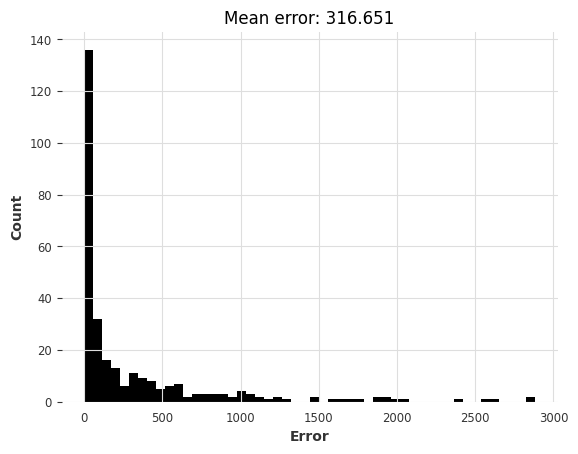

In [28]:
maes_baseline, time_baseline, preds_baseline = eval_local_model(train_val, test, NaiveMovingAverage, mae, prediction_horizon=6, input_chunk_length=12)

### TiDE model

In [29]:
# PyTorch Lightning Trainer arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

pl_trainer_kwargs = {
    "max_epochs": 50,
    #"accelerator": "gpu", # uncomment for gpu use
    "callbacks": [EarlyStopping(**early_stopping_args)],
    "enable_progress_bar":True
}

common_model_args = {
    "output_chunk_length": 6,
    "input_chunk_length": 12,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,
}

In [30]:
encoders = {
    "position": {"past": ["relative"], "future": ["relative"]},
    "transformer": Scaler(),
}

best_hp = {
 'optimizer_kwargs': {'lr':0.0001},
 'loss_fn': MAELoss(),
 'use_layer_norm': True,
 'use_reversible_instance_norm': True,
 'add_encoders':encoders,
 }

In [31]:
start = time.time()
## COMMENT TO LOAD PRE-TRAINED MODEL
fit_mixed_covariates_model(
    model_cls = TiDEModel,
    common_model_args = common_model_args,
    specific_model_args = best_hp,
    model_name = 'TiDE_model',
    past_cov = past_cov,
    future_cov = future_cov,
    train_series = train,
    val_series = val,
)
time_tide = time.time() - start

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MAELoss          | 0      | train
1  | train_criterion       | MAELoss          | 0      | train
2  | val_criterion         | MAELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | past_cov_projection   | _ResidualBlock   | 1.1 K  | train
7  | future_cov_projection | _ResidualBlock   | 1.2 K  | train
8  | encoders              | Sequential       | 51.3 K | train
9  | decoders

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [32]:
best_tide = TiDEModel.load_from_checkpoint(model_name='TiDE_model', best=True)

/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

In [33]:
preds_tide = best_tide.predict(
                    series            = train_val,
                    past_covariates   = past_cov,
                    future_covariates = future_cov,
                    n                 = 6
                )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

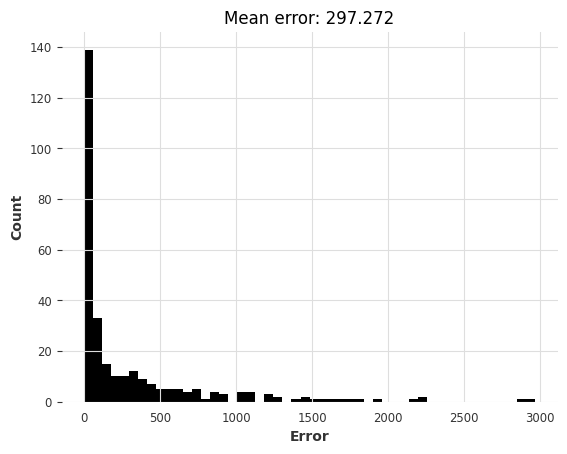

In [34]:
maes_tide = eval_forecasts(preds_tide, test, mae, plot=True)

### TFT model

In [35]:
# PyTorch Lightning Trainer arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 50,
    "min_delta": 1e-3,
    "mode": "min",
}

pl_trainer_kwargs = {
    "max_epochs": 200,
    #"accelerator": "gpu", # uncomment for gpu use
    "callbacks": [EarlyStopping(**early_stopping_args)],
    "enable_progress_bar":True
}

common_model_args = {
    "output_chunk_length": 6,
    "input_chunk_length": 12,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,
}

In [36]:
encoders = {
    "position": {"past": ["relative"], "future": ["relative"]},
    "transformer": Scaler(),
}

best_hp = {
 'optimizer_kwargs': {'lr':0.0001},
 'loss_fn': MAELoss(),
 'use_reversible_instance_norm': True,
 'add_encoders':encoders,
 }

In [37]:
start = time.time()
## COMMENT TO LOAD PRE-TRAINED MODEL
fit_mixed_covariates_model(
    model_cls = TFTModel,
    common_model_args = common_model_args,
    specific_model_args = best_hp,
    model_name = 'TFT_model',
    past_cov = past_cov,
    future_cov = future_cov,
    train_series = train,
    val_series = val,
)
time_tft = time.time() - start

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MAELoss                          | 0      | train
1  | train_criterion                   | MAELoss                          | 0      | train
2  | val_criterion                     | MAELoss                          | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | rin                               | RINorm                      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [38]:
best_tft = TFTModel.load_from_checkpoint(model_name='TFT_model', best=True)

/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

In [39]:
preds_tft = best_tft.predict(
                    series            = train_val,
                    past_covariates   = past_cov,
                    future_covariates = future_cov,
                    n                 = 6
                )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

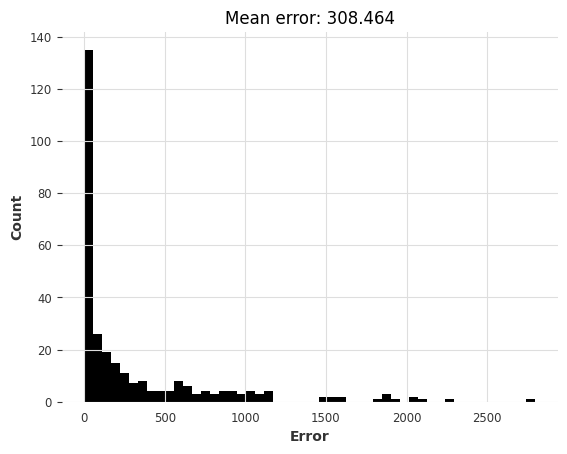

In [40]:
maes_tft = eval_forecasts(preds_tft, test, mae, plot=True)

## Evaluation

In [55]:
print(f'Moving Average Baseline - MAE: {np.mean(maes_baseline):.3f} - Time: {time_baseline:.0f} seconds')
print(f'TiDE - MAE: {np.mean(maes_tide):.3f} - Time: {time_tide/60:.0f} minutes')
print(f'TFT - MAE: {np.mean(maes_tft):.3f} - Time: {time_tft/60:.0f} minutes')

Moving Average Baseline - MAE: 316.651 - Time: 1 seconds
TiDE - MAE: 297.272 - Time: 4 minutes
TFT - MAE: 308.464 - Time: 23 minutes


In [45]:
processed_tide = process_predictions(preds_tide, series_raw, ['Agency','Product'])
processed_tft = process_predictions(preds_tft, series_raw, ['Agency','Product'])
processed_baseline = process_predictions(preds_baseline, series_raw, ['Agency','Product'])

processed_tide.rename(columns={'Volume': 'TiDE'}, inplace=True)
processed_tft.rename(columns={'Volume': 'TFT'}, inplace=True)
processed_baseline.rename(columns={'Volume': 'Baseline'}, inplace=True)

predictions = dataset.merge(processed_tide, on=['Agency','Product','Date'], how='left')
predictions = predictions.merge(processed_tft, on=['Agency','Product','Date'], how='left')
predictions = predictions.merge(processed_baseline, on=['Agency','Product','Date'], how='left')
predictions = predictions.dropna(subset=['TiDE','TFT','Baseline']).reset_index(drop=True)

In [46]:
predictions

,Agency,Product,Date,Volume,Price,Discount,Special_days,EMA_4,MA_4,TiDE,TFT,Baseline
0,Agency_01,SKU_01,2017-07-01,59.2920,1688.796106,0.172464,0,64.105705,66.987000,62.749593,66.277812,57.384000
1,Agency_01,SKU_01,2017-08-01,66.4200,1689.869512,0.171856,0,65.031423,67.662000,70.848073,67.019730,57.630000
2,Agency_01,SKU_01,2017-09-01,95.9040,1690.939823,0.299379,1,77.380454,76.464000,73.068535,71.753536,55.646500
3,Agency_01,SKU_01,2017-10-01,52.8120,1688.086020,0.242722,0,67.553072,68.607000,67.657347,63.117428,54.001708
4,Agency_01,SKU_01,2017-11-01,37.9080,1622.877493,0.173157,1,55.695043,63.261000,57.198632,63.771675,53.407851
...,...,...,...,...,...,...,...,...,...,...,...,...
1765,Agency_60,SKU_07,2017-08-01,67.7025,1658.248654,0.129990,0,67.526131,67.370625,71.239070,64.018663,76.417292
1766,Agency_60,SKU_07,2017-09-01,46.9050,1659.928685,0.129859,1,59.277678,62.835000,77.583632,70.341845,75.262899
1767,Agency_60,SKU_07,2017-10-01,56.1975,1658.513948,0.121018,0,58.045607,57.525000,86.348156,64.243714,75.561058
1768,Agency_60,SKU_07,2017-11-01,81.4200,1662.325037,0.150915,1,67.395364,63.056250,77.585233,72.422362,72.602187


In [47]:
pwmae_tide = price_weighted_mae(predictions.TiDE, predictions.Volume, predictions.Price)
pwmae_tft = price_weighted_mae(predictions.TFT, predictions.Volume, predictions.Price)
pwmae_base = price_weighted_mae(predictions.Baseline, predictions.Volume, predictions.Price)

In [56]:
print(f'Moving Average Baseline - Price Weighted MAE: {pwmae_base:.3f} - Time: {time_baseline:.0f} seconds')
print(f'TiDE - Price Weighted MAE: {pwmae_tide:.3f} - Time: {time_tide/60:.0f} minutes')
print(f'TFT - Price Weighted MAE: {pwmae_tft:.3f} - Time: {time_tft/60:.0f} minutes')
print('')
print(f'Improvement of the baseline with TiDE in MAE {round((1- (np.mean(maes_tide)/np.mean(maes_baseline)))*100,2)} %')
print(f'Improvement of the baseline with TiDE in Price Weighted MAE {round((1- (pwmae_tide/pwmae_base)) *100,2)}%')
print('')
print(f'Improvement of the baseline with TFT in MAE {round((1- (np.mean(maes_tft)/np.mean(maes_baseline)))*100,2)} %')
print(f'Improvement of the baseline with TFT in Price Weighted MAE {round((1- (pwmae_tft/pwmae_base)) *100,2)}%')

Moving Average Baseline - Price Weighted MAE: 579390.188 - Time: 1 seconds
TiDE - Price Weighted MAE: 541011.250 - Time: 4 minutes
TFT - Price Weighted MAE: 573171.500 - Time: 23 minutes

Improvement of the baseline with TiDE in MAE 6.12 %
Improvement of the baseline with TiDE in Price Weighted MAE 6.62%

Improvement of the baseline with TFT in MAE 2.59 %
Improvement of the baseline with TFT in Price Weighted MAE 1.07%


In [ ]:
# End